# Visualize classification better

## Setup

Imports

In [1]:
import os
import re
import gc
import sys
import glob
import yaml
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time, sleep
import aicspylibczi as aplc
import matplotlib.pyplot as plt
from collections import defaultdict

Workdir

In [2]:
cluster = ""
workdir = "/workdir/bmg224/harvard_dental/manuscript/code"
os.chdir(cluster + workdir)


In [70]:
os.getcwd()

'/local/workdir/bmg224/harvard_dental/manuscript/code'

Special imports

In [21]:
%load_ext autoreload
%autoreload 2
functions_path = '/workdir/bmg224/manuscripts/mgefish/code/functions'

sys.path.append(cluster + functions_path)

# import fn_general_use as fgu
import image_plots as ip
import segmentation_func as sf
# import fn_hiprfish_classifier as fhc
import fn_spectral_images as fsi
# import fn_analysis_plots as apl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get example image

Name

In [31]:
date = '2022_12_16'
sn = 'harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01'

Filename formats

In [8]:

out_dir = '../outputs/segmentation_2024_03_07/{date}/{date}_{sn}'

out_dir_seg = out_dir + "/segs"
ofmt = '/{date}_{sn}_M_{m}'
seg_fmt = out_dir_seg + ofmt + "_seg.npy"
props_fmt = out_dir_seg + ofmt + "_props.csv"

out_fmt_clust = out_dir + "/cluster/{date}_{sn}"
clust_fmt = out_fmt_clust + "_clusters.npy"
mlab_fmt = out_fmt_clust + "_dict_index_mlab.yaml"

out_fmt_classif = out_dir + "/classif"
classif_fmt = out_fmt_classif + "/{date}_{sn}_dict_cluster_barcode.yaml"


CZI filenames

In [10]:
table_fn = 'input_table_test.csv'
input_table = pd.read_csv(table_fn)
czi_fns = input_table.filenames.values
czi_fns

array(['../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01tile_las_488.czi',
       '../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01tile_las_514.czi',
       '../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01tile_las_561.czi'],
      dtype=object)

Config file

In [19]:
with open('config.yaml','r') as f:
    config = yaml.safe_load(f)
config

{'functions_path': '../../../manuscripts/mgefish/code/functions',
 'input_table': 'input_table_test.csv',
 'output_dir': '../outputs/segmentation_2024_03_07',
 'max_shift': 500,
 'gauss': 3,
 'diff_gauss': '(2, 3)',
 'bg_smoothing': 5,
 'n_clust_bg': 10,
 'top_n_clust_bg': 9,
 'imin': 2,
 'dpi': 500,
 'cb_col': 'k',
 'n_clust': 25,
 'spec_dims': '(10,5)',
 'umap_dims': '(5,5)',
 's_u': 1,
 'alpha_u': 0.25,
 'cmap_u': 'Spectral',
 'ref_dir': '../../../manuscripts/mgefish/data/unused/fig_5/HiPRFISH_reference_spectra',
 'color_legend': {'label_color': 'k', 'ft': 8, 'dims': '(1.5,2.5)'},
 'moran': {'radius_um': 3,
  'lw': 1,
  'ft': 7,
  'dims': '(2, 1)',
  'l_col': 'k',
  'pad': 0.2,
  'dpi': 500,
  'spot_size': 1,
  'dims_im': '(4,4)'},
 'l_func': {'lw': 2, 'dims': '(2,1)', 'ft': 7, 'dmax': 205, 'stepsize': 5},
 'cluster_size': {'lw': 1,
  'ft': 7,
  'dims_cl': '(4,4)',
  'spot_size': 1,
  'dpi': 250,
  'dims_pl': '(2,1)',
  'min_cluster_size': 10},
 'min_box_size_um': 10,
 'fuzzy_box_co

## Segment with no boundary

get shifts

In [17]:
m = 1

M, mtype = fsi.get_ntiles(czi_fns[0])
resolutions = [fsi.get_resolution(fn) for fn in czi_fns]
lasers = [fsi.get_laser(fn) for fn in czi_fns]

raws = [fsi.load_raw(fn, m, mtype) for fn in czi_fns]
raws = [fsi.reshape_aics_image(r) for r in raws]
# some images have different pixel resolution, correct that
raws = fsi.match_resolutions_and_size(raws, resolutions)
image_max_norm = [fsi.max_norm(r) for r in raws]
sh = fsi._get_shift_vectors(image_max_norm)
raws_shift = fsi._shift_images(
    raws, sh, max_shift=config['max_shift']
)


0 0 0
1 -43 -26
2 -43 -28
[array([0., 0.]), array([-43., -26.]), array([-43., -28.])]


Segment

In [24]:
stack = np.dstack(raws_shift)
stack_sum = np.sum(stack, axis=2)
pre = sf.pre_process(
    stack_sum, 
    gauss=config['gauss'], 
    diff_gauss=eval(config['diff_gauss'])
    )
mask = sf.get_background_mask(
    stack_sum,
    bg_smoothing=config['bg_smoothing'],
    n_clust_bg=config['n_clust_bg'],
    top_n_clust_bg=config['top_n_clust_bg'],
)
seg = sf.segment_02(pre, mask)
props = sf.measure_regionprops(seg, stack_sum)



Plot seg

(<Figure size 1440x1440 with 1 Axes>, <Axes:>, [[], []])

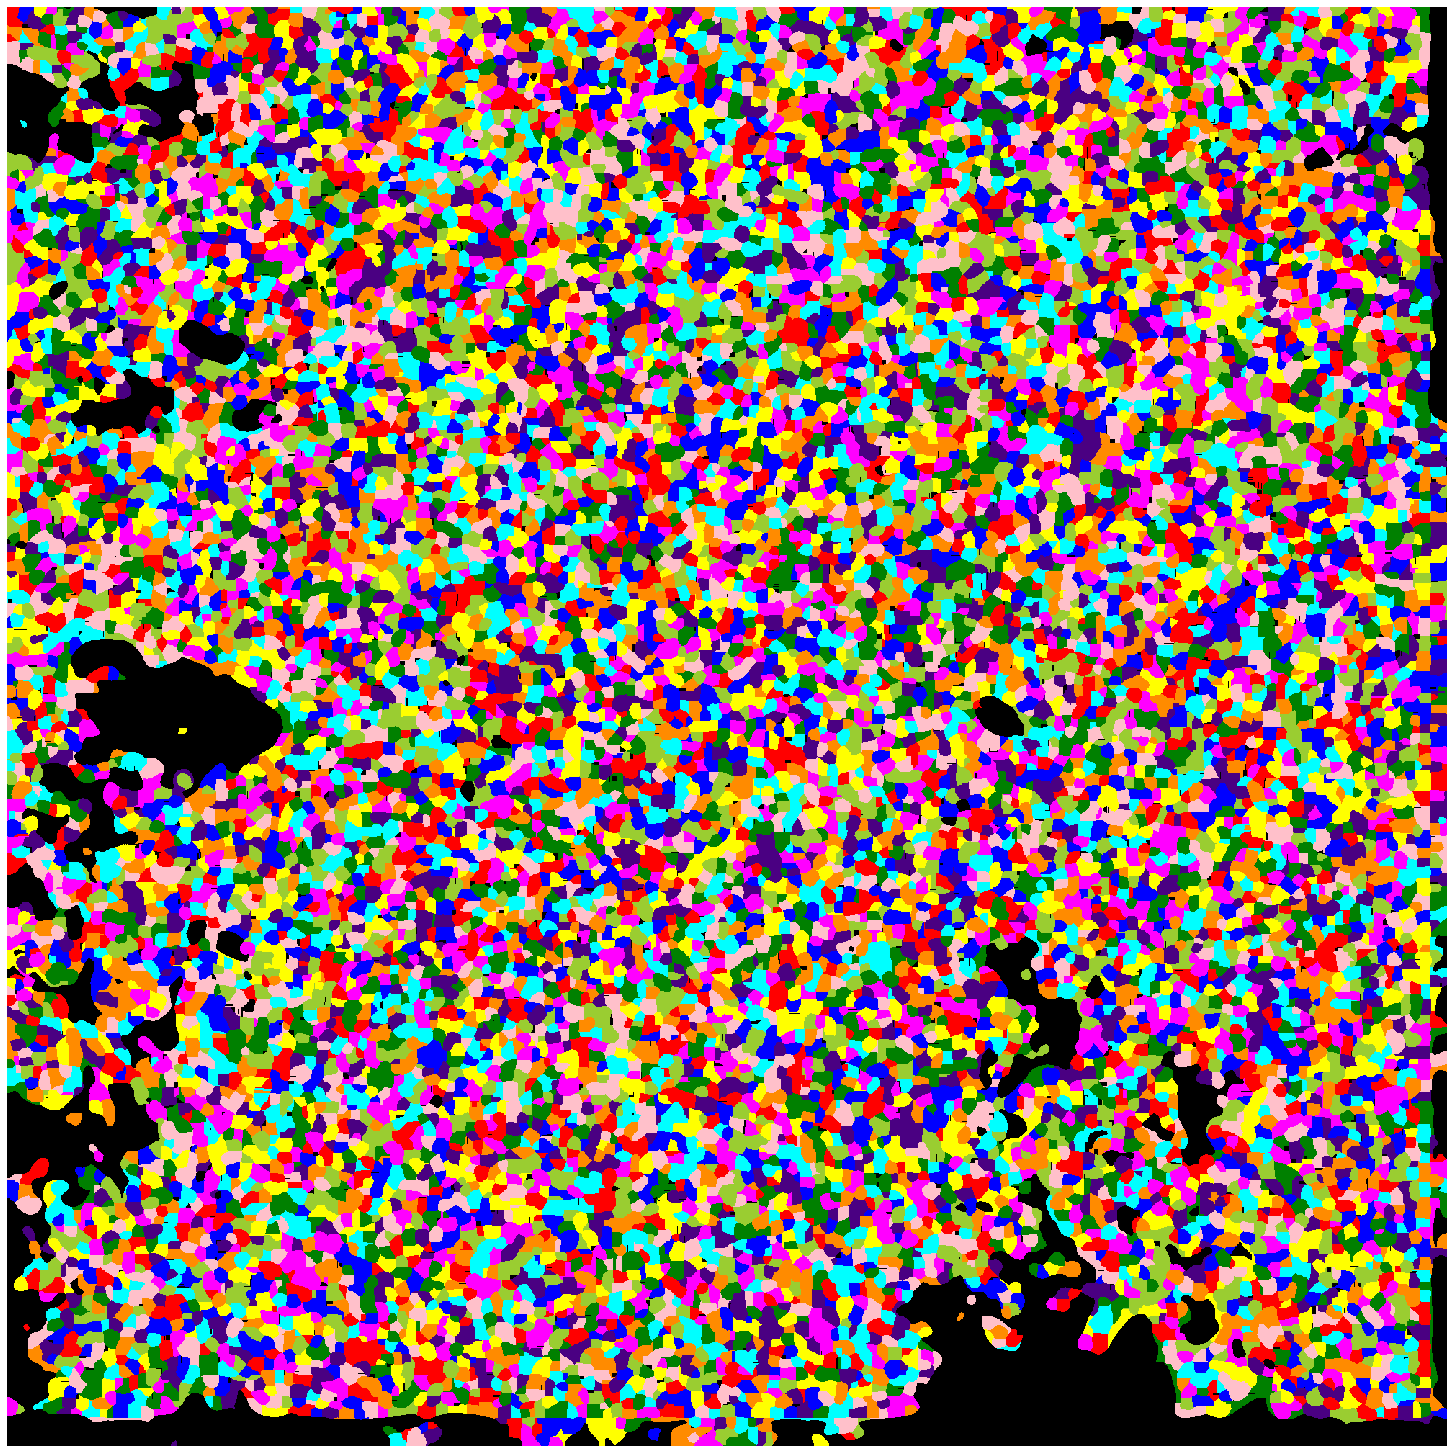

In [69]:
seg_rgb = ip.seg2rgb(seg)
ip.plot_image(seg_rgb, im_inches=20)

Load old files

In [77]:
# Props
props_old = pd.read_csv(props_fmt.format(date=date, sn=sn, m=m))

# labels
mlab_fn = mlab_fmt.format(date=date, sn=sn)
with open(mlab_fn, 'r') as f:
    dict_m_lab_ind = yaml.unsafe_load(f)

# Cluster
clust_agg = np.load(clust_fmt.format(date=date, sn=sn))

# Classification
classif_fn = classif_fmt.format(date=date,sn=sn)
with open(classif_fn, 'r') as f:
    dict_cl_bc = yaml.unsafe_load(f)

# color
sciname_list = [
    'Pasteurellaceae',
    'Corynebacterium',
    'Veillonella',
    'Actinomyces',
    'Selenomonas',
    'Rothia',
    'Porphyromonas',
    'Capnocytophaga',
    'Prevotella',
    'Streptococcus',
    'Gemella',
    'Campylobacter',
    'Lautropia',
    'Leptotrichia',
    'Neisseriaceae',
    'Treponema',
    'Fusobacterium',
    'TM7'
]
# colors = plt.get_cmap('tab20').colors
cmap = plt.get_cmap('gist_rainbow')
colors = [cmap(i) for i in np.linspace(0,1,len(sciname_list))]
# colors = [c + (1,) for c in colors]
dict_sciname_color = dict(zip(sciname_list, colors))
dict_sciname_color['Neisseria'] = dict_sciname_color['Neisseriaceae']
dict_sciname_color['Saccharibacteria'] = dict_sciname_color['TM7']

# barcode sciname
bmg224_dir = '../../..'
dict_date_pdfn = {
    '2022_12_16': [
        bmg224_dir 
        + '/manuscripts/mgefish/data/HiPRFISH_probe_design' 
        + '/welch2016_5b_no_633_channel.csv',
        '5bit_no633'
    ],
    '2023_02_08': [
        bmg224_dir 
        + '/manuscripts/mgefish/data/HiPRFISH_probe_design' 
        + '/welch2016_5b_no_633_channel.csv',
        '5bit_no633'
    ],
    '2023_02_18': [
        bmg224_dir 
        + '/manuscripts/mgefish/data/HiPRFISH_probe_design'
        + '/welch2016_5b_no_633_channel.csv',
        '5bit_no633'
    ],
    '2023_10_16': [
        bmg224_dir 
        + '/harvard_dental/pick_distant_barcodes/2023_08_01_order'
        + '/welch2016_7b_distant_v2.csv',
        '7bit_no405'
    ],
    '2023_10_18': [
        bmg224_dir 
        + '/harvard_dental/pick_distant_barcodes/2023_08_01_order'
        + '/welch2016_7b_distant_v2.csv',
        '7bit_no405'
    ],
}
pdfn, bc_type = dict_date_pdfn[date]
probe_design = pd.read_csv(pdfn)
barcodes = probe_design['code']
sci_names = probe_design['sci_name']
dict_bc_sciname = dict(zip(barcodes, sci_names))


(<Figure size 432x720 with 1 Axes>, <AxesSubplot:ylabel='Genus'>)

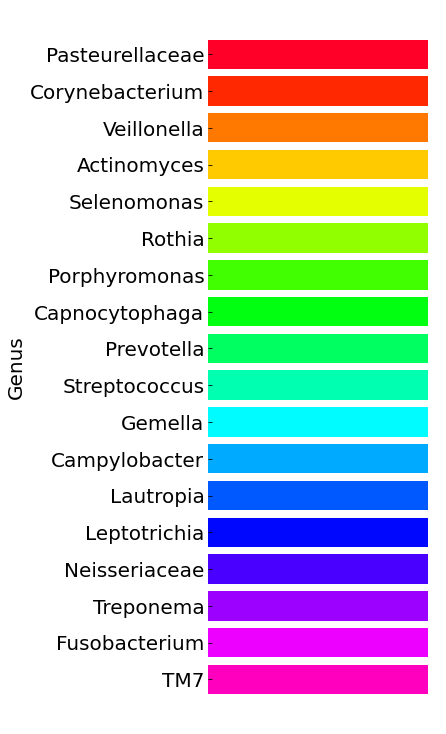

In [83]:
ip.taxon_legend(sciname_list, colors)

(<Figure size 432x720 with 1 Axes>, <AxesSubplot:ylabel='Genus'>)

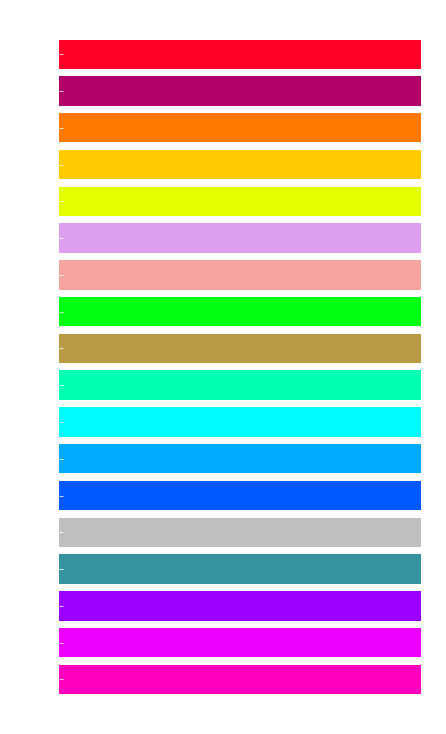

In [106]:
colors_new = colors.copy()
colors_new[13] = [0.75,0.75,0.75]
colors_new[1] = np.array([176,2,104])/255
colors_new[8] = np.array([184,155,69])/255
colors_new[6] = np.array([245,164,159])/255
colors_new[5] = np.array([221,159,239])/255
colors_new[14] = np.array([54,148,161])/255
ip.taxon_legend(np.arange(len(colors_new)), colors_new, label_color='w', face_color='k')

(<Figure size 432x720 with 1 Axes>, <AxesSubplot:ylabel='Genus'>)

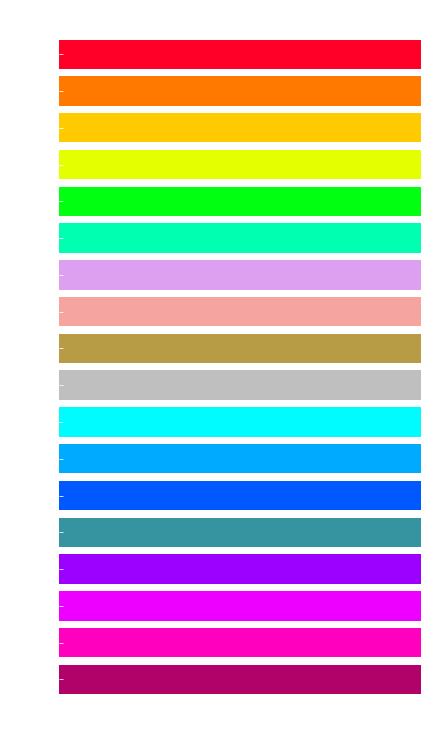

In [108]:
col_03 = colors_new.copy()
col_03.insert(17, col_03.pop(1))
col_03.insert(4, col_03.pop(6))
col_03.insert(9, col_03.pop(12))
col_03.insert(5, col_03.pop(8))
ip.taxon_legend(np.arange(len(col_03)), col_03, label_color='w', face_color='k')

Map new seg to old seg

In [78]:
dict_nlab_color = {}
for i, row in props_old.iterrows():
    c = eval(row.centroid)
    c = [int(c_) for c_ in c]
    lab = row.label
    ind = dict_m_lab_ind[m][lab]
    cl = clust_agg[ind]
    bc = dict_cl_bc[cl]
    sciname = dict_bc_sciname[bc]
    color = dict_sciname_color[sciname]
    lnew = seg[c[0],c[1]]
    if lnew:
        dict_nlab_color[lnew] = color


Write new recolor function

In [75]:
def seg_2_rgb_dict(seg, dict_lab_col, dict_lab_bbox, raw=None, base_color=None):
    """
    Convert segmentation numpy array to RGB image

    seg - 2d array(int or str) - objects are adjacent pixels with the same value
    dict_lab_col - dictionary(int or str -> list or tup) - map objects in seg to an RGB or RGBA color
    dict_lab_bbox - dictinoary(int or str -> list(int) or tup(int) or str(comma separated integers)) -
        map objects in seg to a bounding box
        bounding box has format (row min, column min, row max, column max)
    """
    rgb_shape = len(dict_lab_col[list(dict_lab_col.keys())[0]])  # Determine RGB or RGBA
    if base_color is None:
        base_color = np.zeros(rgb_shape)
    else:
        base_color = np.array(base_color)
    rgb = np.ones(seg.shape + (rgb_shape,)) * base_color[None,:]  # initiate empty image
    for l, b in dict_lab_bbox.items():
        b = eval(b) if isinstance(b, str) else b  # convert to list if string
        rgb_sub = rgb[b[0] : b[2], b[1] : b[3]]  # extract current RGB bbox
        seg_sub = seg[b[0] : b[2], b[1] : b[3]] == l  # Extract object
        color = np.array(dict_lab_col[l])  # Get the object's new color
        rgb_nonobj = rgb_sub * np.dstack(
            [~seg_sub] * rgb_shape
        )  # keep everything already existing in the rgb
        if raw is None:
            raw_sub = np.ones_like(seg_sub)  
        else:
            raw_sub = raw[b[0] : b[2], b[1] : b[3]]
        rgb_obj = seg_sub[:, :, None] * color[None, :] * raw_sub[:,:,None]  # recolor the object
        rgb[b[0] : b[2], b[1] : b[3], :] = (
            rgb_nonobj + rgb_obj
        )  # write the recolored object to the rgb
    return rgb


Adjust raw image

(<Figure size 720x720 with 1 Axes>,
 <Axes:>,
 [<Figure size 720x72 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1ca9d64f40>])

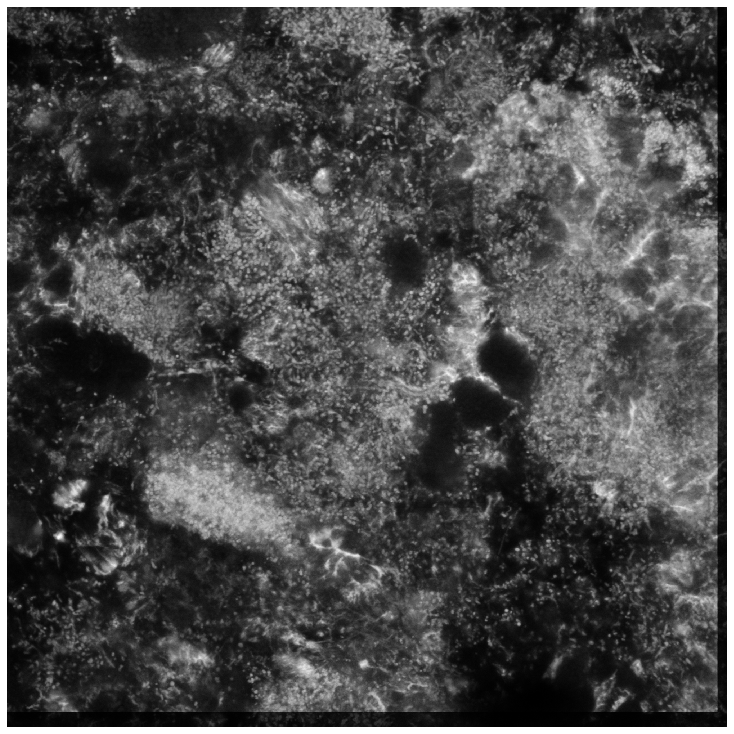

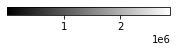

In [57]:
ip.plot_image(stack_sum, cmap='gray', im_inches=10)

(<Figure size 720x720 with 1 Axes>,
 <Axes:>,
 [<Figure size 720x72 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1ca9e70940>])

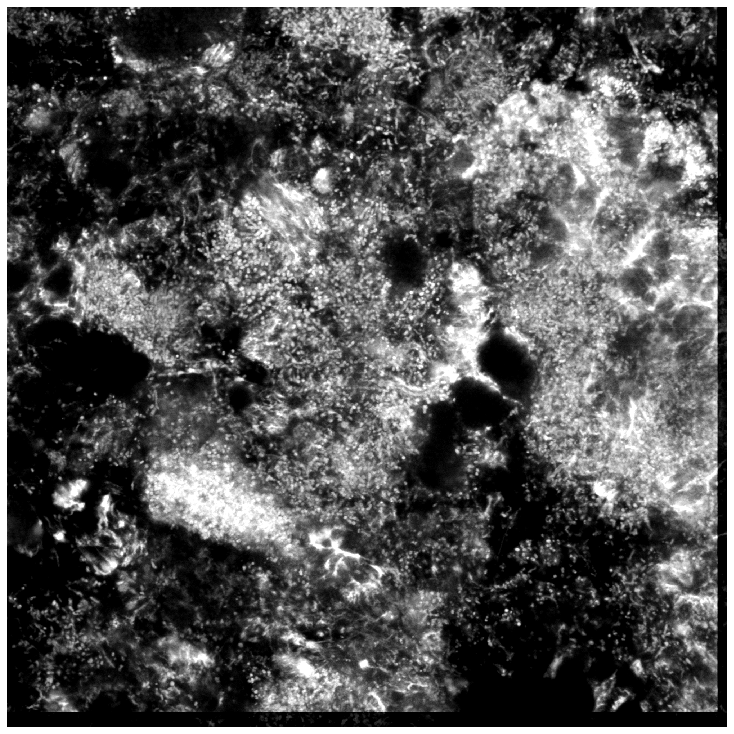

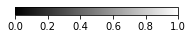

In [64]:
clips = [2.5e5,2e6]
stack_sum_norm = fsi.max_norm(stack, type='sum', c=clips)
ip.plot_image(stack_sum_norm, cmap='gray', im_inches=10)

Recolor seg

(<Figure size 360x360 with 1 Axes>, <Axes:>, [[], []])

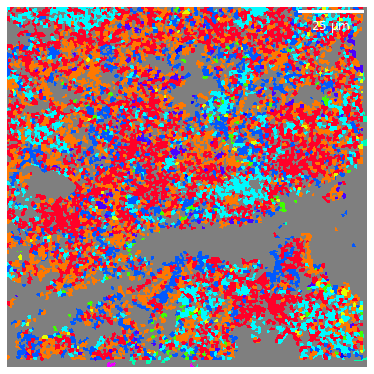

In [82]:
dict_lab_bbox = dict(zip(props.label.values,props.bbox.values))
dict_nlab_bbox = {l: dict_lab_bbox[l] for l in dict_nlab_color.keys()}
seg_classif = seg_2_rgb_dict(
    seg, 
    dict_nlab_color, 
    dict_nlab_bbox, 
    base_color=(0.5,0.5,0.5,1)
)
ip.plot_image(
    seg_classif, 
    im_inches=5,
    scalebar_resolution=resolutions[0]*1e6,
    ft=12
    )

### Match intensities across images

0 0 0
1 -43 -22
2 -41 -19
0 0 0
1 -43 -26
2 -43 -28
0 0 0
1 -44 -26
2 -44 -29
0 0 0
1 -40 -24
2 -39 -20
0 0 0
1 -41 -27
2 -41 -28
0 0 0
1 -41 -32
2 -36 -53
0 0 0
1 -42 -25
2 -43 -31
0 0 0
1 -44 -29
2 -46 -32
0 0 0
1 -43 -31
2 -37 -58


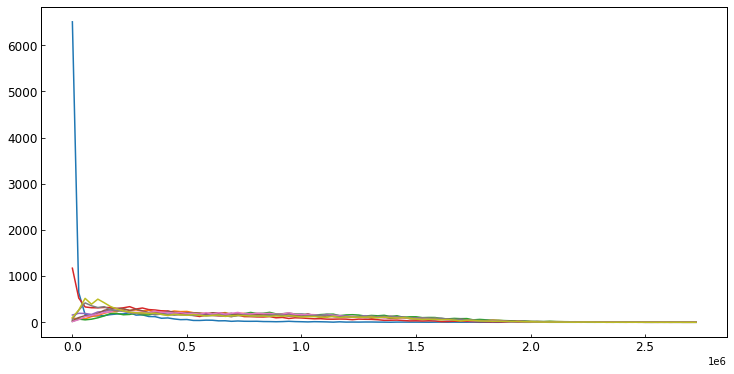

In [73]:
n = 10000
bins = np.linspace(0,2.75e6,100)
fig, ax = ip.general_plot(dims=(10,5))
for m in range(M):
    # Get shifts
    raws = [fsi.load_raw(fn, m, mtype) for fn in czi_fns]
    raws = [fsi.reshape_aics_image(r) for r in raws]
    # some images have different pixel resolution, correct that
    raws = fsi.match_resolutions_and_size(raws, resolutions)
    image_max_norm = [fsi.max_norm(r) for r in raws]
    sh = fsi._get_shift_vectors(image_max_norm)
    raws_shift = fsi._shift_images(
        raws, sh, max_shift=config['max_shift']
    )

    # PLot intensities
    stack = np.dstack(raws_shift)
    stack_sum = np.sum(stack, axis=2)
    vals = np.random.choice(stack_sum.ravel(), size=n, replace=False)
    counts, b = np.histogram(vals, bins=bins)
    x = b[:-1]
    ax.plot(x, counts)

